# Iterative Training on Coughvid + Coswara data (Part 1: independent)

## 1. Preparing the environment

First, the colab is mounted onto the drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Libraries are imported for processing and training purpose

In [ ]:
# File handling
import os
import pandas as pd

In [ ]:
# Audio data handling
import librosa
import librosa.util
import numpy as np

In [ ]:
# Machinelearning
# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# tensor flow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Reshape, Bidirectional, Input, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications

from tensorflow_hub import KerasLayer

# Regularization
from tensorflow.keras.regularizers import l2

# Metrics
from tensorflow.keras.metrics import Precision, Recall, AUC

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# !nvidia-smi

In [ ]:
# # run this to clear GPU memory if needed
# import torch
# torch.cuda.empty_cache()

# import tensorflow as tf
# tf.keras.backend.clear_session()

## 2. Data preparation

You should only use the training and testing folder

In [ ]:
# check and verify the folders to access the data prepared earlier
metadata_path = "/content/drive/My Drive/AML/Data/dataset5_combined_coughvid_coswara/" # update this to local version
print(os.listdir(metadata_path))

['labels', 'combined_train_16mar', 'combined_test_16mar']


Specify the training and testing file folder (loading file names)

In [ ]:
# for standarising in all sub-datasets, a function is used
def list_files(directory, label):
    files_list = os.listdir(directory)
    total_files = len(files_list)
    sample_files = files_list[:10]
    print(f"Total {label} Files: {total_files}")
    print(f"Sample {label} Files:", sample_files)
    return total_files

In [ ]:
# Show distribution of labels
def plot_distribution(counts, labels, title):
    total = sum(counts)
    percentages = [(count / total) * 100 for count in counts]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labels, counts, color=['lightblue', 'orange'])
    plt.xlabel("Dataset Type")
    plt.ylabel("Number of Files")
    plt.title(title)

    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width()/2, 10, f'{percentage:.1f}%',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

In [ ]:
train_dir = os.path.join(metadata_path, 'combined_train_16mar') # use training folder specified above
test_dir = os.path.join(metadata_path, 'combined_test_16mar') # use test folder specified above

# Process train and test directories
total_train_files = list_files(train_dir, "Train")
total_test_files = list_files(test_dir, "Test")

Total Train Files: 2271
Sample Train Files: ['53d69964-ae7d-4ccc-a297-91a9b21c772e.wav', '8b66adaa-ff22-45f1-b74e-9719c0d544f9.wav', '35ec6e33-eeeb-4734-9a52-c37a949e5443.wav', '90df4728-8750-4646-a0a4-027f2c9cd544.wav', '076f59de-0637-4ee1-951c-f2e0784e8a53.wav', '9a70cfcf-2df1-4bbc-aed8-aa9afa094a9f.wav', '1cc88f3a-3529-4cb8-a167-fc0cb5b0bfb6.wav', '3a325d6e-929d-48f4-b640-36e08fa37cf4.wav', '34b77763-a4a4-4beb-aeaa-02ef8298ef31.wav', '3b6a0157-04a2-46cd-b5a7-299595293a2d.wav']
Total Test Files: 468
Sample Test Files: ['4fa54167-06c6-485a-a7b5-4b3696aa1393.wav', 'ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav', '39e4cc19-0db4-492a-b580-9fc4e4ab62ea.wav', '9f40d734-f22c-400f-abed-87c15bedc69c.wav', 'a08ada1f-32e6-40cf-9513-57cf411cf97d.wav', '69e7b5c5-0469-42dd-b68f-9a7f7637425b.wav', 'be920126-b1e2-4117-84e2-461b2230e46e.wav', 'd11e501c-6f48-4028-8198-9075c67ce238.wav', '37347587-048a-4a1c-a100-7cf820711428.wav', 'ae321315-0798-4b11-a088-a2acdd099ffc.wav']


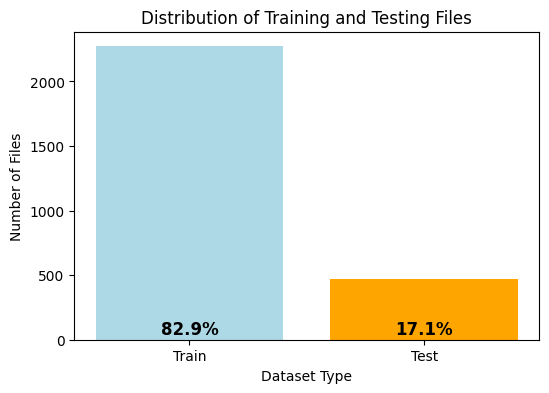

In [ ]:
# Plot distribution
plot_distribution([total_train_files, total_test_files], ["Train", "Test"], "Distribution of Training and Testing Files")

Loading the labels based on filenames above

In [ ]:
def load_labels_combined_train(file_path, dataset_name):
    data = pd.read_csv(file_path)
    data['health_status'] = data['health_status'].astype(int)
    print(f"Unique health_status labels in {dataset_name} set:", data['health_status'].unique())
    label_dict = {
      f"{id_}.wav" if not id_.endswith(".wav") else id_: label
      for id_, label in zip(data['filename'], data['health_status'])
  }
    print(f"Sample {dataset_name} labels:", list(label_dict.items())[:5])
    print(f"{len(label_dict)} {dataset_name} files labeled correctly.")
    return label_dict, data['health_status'].value_counts().to_dict()

In [ ]:
def load_labels_combined_test(file_path, dataset_name):
    data = pd.read_csv(file_path)
    print(f"Unique health_status labels in {dataset_name} set:", data['health_status'].unique())
    label_dict = {f"{id_}.wav": label for id_, label in zip(data['uuid'], data['health_status'])}
    print(f"Sample {dataset_name} labels:", list(label_dict.items())[:5])
    print(f"{len(label_dict)} {dataset_name} files labeled correctly.")
    return label_dict, data['health_status'].value_counts().to_dict()

In [ ]:
# move on to the labels folder
labels_path = os.path.join(metadata_path, "labels")

train_labels_path = os.path.join(labels_path, 'combined_train_16mar.csv') # use training label specified above
test_labels_path = os.path.join(labels_path, 'combined_test_16mar.csv') # use test label specified above

In [ ]:
# Load and process train and test label datasets
train_label_dict, train_label_counts = load_labels_combined_train(train_labels_path, "training")
test_label_dict, test_label_counts = load_labels_combined_test(test_labels_path, "testing")

Unique health_status labels in training set: [0 1]
Sample training labels: [('aa78817e-f5e3-470b-b516-6006c59fb1fa.wav', 0), ('7b7f6998-7f52-475f-8bbd-e76d80eafd91.wav', 0), ('506b5606-cecb-4fba-8723-c4a2bfb8b038.wav', 1), ('0f79324e-9dc6-4f6c-8c13-2a3041f044d1.wav', 0), ('e1d7fad3-6eb9-44db-ad0a-1f25cd555b53.wav', 1)]
2271 training files labeled correctly.
Unique health_status labels in testing set: [1 0]
Sample testing labels: [('7869b66e-5c53-42b8-8741-8e7398f78137.wav', 1), ('e80023d9-392a-407a-9580-9c66eb45d7bd.wav', 0), ('37347587-048a-4a1c-a100-7cf820711428.wav', 0), ('f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav', 0), ('ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav', 0)]
468 testing files labeled correctly.


In [ ]:
import re  # Import regular expressions

# Define the regex pattern to check for ".wav.wav" occurrence
pattern = re.compile(r"\wav\.wav")

# Iterate through the labels and check for the pattern
for labels in train_label_dict.keys():
    if pattern.search(labels):  # If ".wav.wav" is found in the filename
        print(f"Invalid filename: {labels}")

In [ ]:
# Check if label count matches file count
if len(train_label_dict) == total_train_files:
    print("Training labels match the number of training files.")
else:
    print(f"Mismatch: {len(train_label_dict)} training labels vs. {total_train_files} training files.")

if len(test_label_dict) == total_test_files:
    print("Testing labels match the number of testing files.")
else:
    print(f"Mismatch: {len(test_label_dict)} testing labels vs. {total_test_files} testing files.")

Training labels match the number of training files.
Testing labels match the number of testing files.


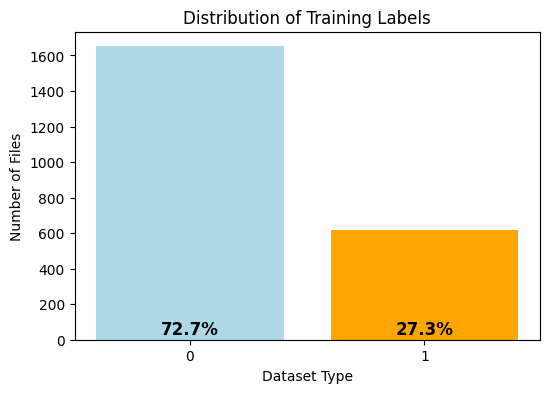

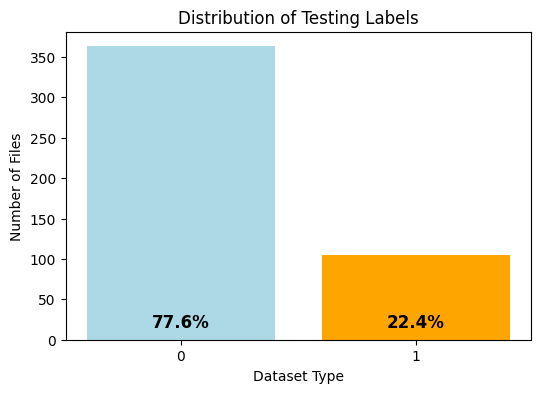

In [ ]:
# Plot distribution of labels in training set
plot_distribution(list(train_label_counts.values()), list(map(str, train_label_counts.keys())), "Distribution of Training Labels")

# Plot distribution of labels in testing set
plot_distribution(list(test_label_counts.values()), list(map(str, test_label_counts.keys())), "Distribution of Testing Labels")

The distribution is the same as expected - very imbalanced

Data are loaded in based on its location, the shapes are checked once again

In [ ]:
def load_audio_dataset(audio_dir, label_dict):
    """Load only the audio files mentioned in the label dictionary."""
    data = []
    labels = []
    filenames = []
    skipped_files = 0  # Counter for skipped files

    for filename in label_dict.keys():  # Iterate only over filenames in label_dict
        file_path = os.path.join(audio_dir, filename)

        # if not os.path.isfile(file_path) or os.path.getsize(file_path) < 10:
        if not os.path.isfile(file_path):
            print(f"Skipping {file_path} (file missing or too small)")
            skipped_files += 1
            continue  # Skip missing or small files

        try:
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=None)
            data.append(audio)
            labels.append(label_dict[filename])
            filenames.append(filename)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            skipped_files += 1
            continue  # Skip problematic files

    print(f"Skipped {skipped_files} files due to errors.")
    return np.array(data, dtype=object), np.array(labels), filenames

In [ ]:
# Load train and test datasets from the same directory
X_train, y_train, train_files = load_audio_dataset(train_dir, train_label_dict)
X_test, y_test, test_files = load_audio_dataset(test_dir, test_label_dict)

# Print dataset summary
print(f"Training Data: {X_train.shape[0]} samples")
print(f"Test Data: {X_test.shape[0]} samples")

# Show sample audio shape
print("\nSample training shapes:")
for i, (audio, name) in enumerate(zip(X_train[:5], train_files[:5])):
    print(f"{name}: {audio.shape}")

print("\nSample test shapes:")
for i, (audio, name) in enumerate(zip(X_test[:5], test_files[:5])):
    print(f"{name}: {audio.shape}")

Skipped 0 files due to errors.
Skipped 0 files due to errors.
Training Data: 2271 samples
Test Data: 468 samples

Sample training shapes:
aa78817e-f5e3-470b-b516-6006c59fb1fa.wav: (71680,)
7b7f6998-7f52-475f-8bbd-e76d80eafd91.wav: (105472,)
506b5606-cecb-4fba-8723-c4a2bfb8b038.wav: (103744,)
0f79324e-9dc6-4f6c-8c13-2a3041f044d1.wav: (12800,)
e1d7fad3-6eb9-44db-ad0a-1f25cd555b53.wav: (33792,)

Sample test shapes:
7869b66e-5c53-42b8-8741-8e7398f78137.wav: (16896,)
e80023d9-392a-407a-9580-9c66eb45d7bd.wav: (38912,)
37347587-048a-4a1c-a100-7cf820711428.wav: (24064,)
f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav: (85504,)
ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav: (64512,)


In [ ]:
def extract_mfcc(audio, sr, n_mfcc=13):
    """Extract MFCC features from raw audio."""
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T  # (frames, features)

# Define a padding/truncation function
def pad_or_truncate(mfcc, target_frames):
    """Pads or truncates MFCC to the target number of frames."""
    num_frames = mfcc.shape[0]

    if num_frames < target_frames:
        # Pad with zeros at the end
        pad_width = target_frames - num_frames
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    elif num_frames > target_frames:
        # Truncate
        mfcc = mfcc[:target_frames, :]

    return mfcc

In [ ]:
# Extract MFCC features at 12kHz
X_train_mfcc = [extract_mfcc(audio, sr=12000) for audio in X_train]
X_test_mfcc = [extract_mfcc(audio, sr=12000) for audio in X_test]

In [ ]:
# Calculate MFCC lengths for all samples
mfcc_lengths = [mfcc.shape[0] for mfcc in X_train_mfcc]

# Compute statistics
min_frames = np.min(mfcc_lengths)
max_frames = np.max(mfcc_lengths)
mean_frames = np.mean(mfcc_lengths)
median_frames = np.median(mfcc_lengths)
percentile_90 = np.percentile(mfcc_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(mfcc_lengths, 95)  # 95th percentile


# Print results
print(f"Min frames: {min_frames}")
print(f"Max frames: {max_frames}")
print(f"Mean frames: {mean_frames}")
print(f"Median frames: {median_frames}")
print(f"90th Percentile frames: {percentile_90}")
print(f"95th Percentile frames: {percentile_95}")

Min frames: 7
Max frames: 528
Mean frames: 91.95948921180097
Median frames: 87.0
90th Percentile frames: 163.0
95th Percentile frames: 184.0


In [ ]:
# Define target frame size
target_frames = 184

# Apply padding/truncation
X_train_mfcc_padded = np.array([pad_or_truncate(mfcc, target_frames) for mfcc in X_train_mfcc])
X_test_mfcc_padded = np.array([pad_or_truncate(mfcc, target_frames) for mfcc in X_test_mfcc])

# Print final shapes
print(f"Processed Training Data Shape: {X_train_mfcc_padded.shape}")
print(f"Processed Test Data Shape: {X_test_mfcc_padded.shape}")

Processed Training Data Shape: (2271, 184, 13)
Processed Test Data Shape: (468, 184, 13)


In [ ]:
# Compute statistics for X_train_mfcc_padded
train_mfcc_lengths = [mfcc.shape[0] for mfcc in X_train_mfcc_padded]

print("Train MFCC Statistics After Padding:")
print(f"Min frames: {np.min(train_mfcc_lengths)}")
print(f"Max frames: {np.max(train_mfcc_lengths)}")
print(f"Mean frames: {np.mean(train_mfcc_lengths)}")
print(f"Median frames: {np.median(train_mfcc_lengths)}")
print(f"90th percentile frames: {np.percentile(train_mfcc_lengths, 90)}")

# Compute statistics for X_test_mfcc_padded
test_mfcc_lengths = [mfcc.shape[0] for mfcc in X_test_mfcc_padded]

print("\nTest MFCC Statistics After Padding:")
print(f"Min frames: {np.min(test_mfcc_lengths)}")
print(f"Max frames: {np.max(test_mfcc_lengths)}")
print(f"Mean frames: {np.mean(test_mfcc_lengths)}")
print(f"Median frames: {np.median(test_mfcc_lengths)}")
print(f"90th percentile frames: {np.percentile(test_mfcc_lengths, 90)}")


Train MFCC Statistics After Padding:
Min frames: 184
Max frames: 184
Mean frames: 184.0
Median frames: 184.0
90th percentile frames: 184.0

Test MFCC Statistics After Padding:
Min frames: 184
Max frames: 184
Mean frames: 184.0
Median frames: 184.0
90th percentile frames: 184.0


In [ ]:
# Convert MFCC lists to NumPy arrays
X_train_mfcc_padded_fed = np.array(X_train_mfcc_padded)
X_test_mfcc_padded_fed = np.array(X_test_mfcc_padded)

# Add channel dimension if using CNNs
X_train_mfcc_padded_fed = X_train_mfcc_padded_fed[..., np.newaxis]
X_test_mfcc_padded_fed = X_test_mfcc_padded_fed[..., np.newaxis]

# Split training data into train and validation sets
X_train_fed, X_val_fed, y_train_fed, y_val_fed = train_test_split(
    X_train_mfcc_padded_fed, y_train, test_size=0.2, stratify=y_train, random_state=37
)

In [ ]:
# Print final shapes
print(f"X_train shape: {X_train_fed.shape}, y_train shape: {y_train_fed.shape}")
print(f"X_val shape: {X_val_fed.shape}, y_val shape: {y_val_fed.shape}")
print(f"X_test shape: {X_test_mfcc_padded_fed.shape}, y_test shape: {y_test.shape}")

X_train shape: (1816, 184, 13, 1), y_train shape: (1816,)
X_val shape: (455, 184, 13, 1), y_val shape: (455,)
X_test shape: (468, 184, 13, 1), y_test shape: (468,)


## 3. Machine Learning 1 (CNN and LSTM on MFCC)

Some functions are defined to understand the training history. They can be used for all models in this notebook

In [ ]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates a given model on test data, generates predictions,
    plots a confusion matrix, and prints a classification report.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test input data
    - y_test: True labels for the test data
    - threshold: Probability threshold for binary classification (default: 0.5)
    """
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)  # Convert probabilities to binary labels

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
def evaluate_test_set(model, X_test, y_test):
    """
    Evaluates the given model on the test set and prints the results.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test input data
    - y_test: True labels for the test data
    """
    # Evaluate the model on the test set
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

Input shape is fixed

In [ ]:
# fix input shape
input_shape = (184, X_train_fed.shape[2], 1)

### Model 1: Simple CNN as a baseline

Firstly, a simple CNN model is trained

SoundCLR

In [ ]:
# Build the CNN model
model_1 = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 184, 13, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 184, 13, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 92, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 92, 6, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 92, 6, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 46, 3, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 46, 3, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 46, 3, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 23, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2944)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │         376,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 478,849 (1.83 MB)

 Trainable params: 478,401 (1.82 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile the model
model_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 30
history_simpleCNN = model_1.fit(X_train_fed, y_train_fed,
                                  batch_size=16,
                                  epochs=num_epochs,
                                  validation_data=(X_val_fed, y_val_fed),
                                  callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.6496 - loss: 0.7941 - precision: 0.3006 - recall: 0.2079 - val_accuracy: 0.7187 - val_loss: 0.5678 - val_precision: 0.3750 - val_recall: 0.0484
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6994 - loss: 0.6234 - precision: 0.4311 - recall: 0.2126 - val_accuracy: 0.7341 - val_loss: 0.5686 - val_precision: 0.7143 - val_recall: 0.0403
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7425 - loss: 0.5706 - precision: 0.4972 - recall: 0.1888 - val_accuracy: 0.7319 - val_loss: 0.5766 - val_precision: 0.5333 - val_recall: 0.1290
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7356 - loss: 0.5514 - precision: 0.5396 - recall: 0.2165 - val_accuracy: 0.7275 - val_loss: 0.5798 - val_precision: 0.5000 - val_recall: 0.0806
Model training completed.


In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_1, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7661 - loss: 0.5132 - precision: 0.4330 - recall: 0.1624
Test Loss: 0.5217
Test Accuracy: 0.7628
Test Precision: 0.4286
Test Recall: 0.1714


It can be seen that the accuracy for the first training of model 1 is quite high (79%) however, the recall is very low. This is likely due to the imbalanced training dataset. The model also conveges very fast. The loss is also quite high

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


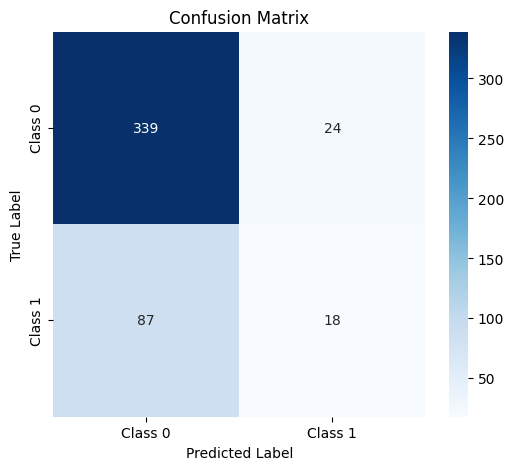


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86       363
           1       0.43      0.17      0.24       105

    accuracy                           0.76       468
   macro avg       0.61      0.55      0.55       468
weighted avg       0.71      0.76      0.72       468



In [ ]:
evaluate_model(model_1, X_test_mfcc_padded_fed, y_test)

As shown in the clasification report, the accuracy 0.76 seems good but F1-score for Class 1 is also very low (0.24), which reflects that the model is not performing well for this class. The poor recall (0.17) for Class1 indicates the model is missing most of the Class 1 instances. The model converges fast. Thus, the class weight will be calculated and tries to address the issue by setting the classweight to be 'balanced

### Model 1.2: added class weight when fitting model 1, no changes in the structure

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Convert class labels to a NumPy array
classes = np.array([0, 1])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fed)

In [ ]:
# Convert to dictionary
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed class weights:", class_weights_dict)

Computed class weights: {0: np.float64(0.6878787878787879), 1: np.float64(1.8306451612903225)}


The model is then retrained using the same structure as model 1

In [ ]:
# Build the CNN model
model_1_1 = Sequential([
    # Convolutional Layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_1_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
model_1_1.fit(X_train_fed, y_train_fed,
            batch_size=16, epochs=30,
            validation_data=(X_val_fed, y_val_fed),
            callbacks=[early_stopping],
            class_weight=class_weights_dict)

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5243 - loss: 1.0511 - precision: 0.2993 - recall: 0.5365 - val_accuracy: 0.5297 - val_loss: 0.6954 - val_precision: 0.3093 - val_recall: 0.5887
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5527 - loss: 0.7448 - precision: 0.3294 - recall: 0.5756 - val_accuracy: 0.5780 - val_loss: 0.6685 - val_precision: 0.3365 - val_recall: 0.5645
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5968 - loss: 0.6884 - precision: 0.3370 - recall: 0.5498 - val_accuracy: 0.6066 - val_loss: 0.6798 - val_precision: 0.3756 - val_recall: 0.6694
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6281 - loss: 0.6363 - precision: 0.3980 - recall: 0.6909 - val_accuracy: 0.6396 - val_loss: 0.6443 - val_precision: 0.3718 - val_recall: 0.4677
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6594 - loss: 0.6320 - precision: 0.4405 - recall: 0.6315 - val_accuracy: 0.6857 - val_los

In [ ]:
evaluate_test_set(model_1_1, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7379 - loss: 0.5292 - precision: 0.4237 - recall: 0.5208
Test Loss: 0.5432
Test Accuracy: 0.7201
Test Precision: 0.3934
Test Recall: 0.4571


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


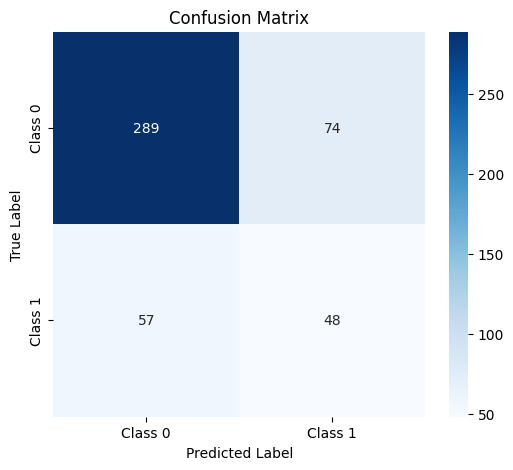


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       363
           1       0.39      0.46      0.42       105

    accuracy                           0.72       468
   macro avg       0.61      0.63      0.62       468
weighted avg       0.74      0.72      0.73       468



In [ ]:
evaluate_model(model_1_1, X_test_mfcc_padded_fed, y_test)

The model sacrificed a bit of overall accuracy (0.76 → 0.72), but have much better balance between classes. The F1 score of Class1 increase although the F1 score of Class2 decrease. The model converges slowly but still overfit.

### Model 2 - Decrease complexity

The following changes are implemented:
*  All layers are regularised as the previouse modle is converging too quickly

*  dropout rate unchanged

*  adaptive learning rate scheduler is inplemented instead of a fixed learning rate

In [ ]:
# Build the CNN model
model_2 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers with L2 Regularization
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_2.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)                   │ (None, 184, 13, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_72               │ (None, 184, 13, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 92, 6, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 92, 6, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_73               │ (None, 92, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 46, 3, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 46, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_74               │ (None, 46, 3, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 23, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 64)                  │          94,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 119,905 (468.38 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.5,           # Factor to reduce the learning rate by (new_lr = old_lr * factor)
    patience=2,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,          # Minimum learning rate
    verbose=1             # Verbosity mode
)

In [ ]:
# Early stopping callback with a larger patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Compile the model
model_2.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model with adaptive learning rate
num_epochs = 50 # allow more potentail epoch, there is early stopping to prevent overfitting
history_regularisedCNN = model_2.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5398 - loss: 3.2759 - precision: 0.3010 - recall: 0.4627 - val_accuracy: 0.4000 - val_loss: 3.0232 - val_precision: 0.2865 - val_recall: 0.8065 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5247 - loss: 3.0207 - precision: 0.3240 - recall: 0.5791 - val_accuracy: 0.4615 - val_loss: 2.9369 - val_precision: 0.3042 - val_recall: 0.7581 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5793 - loss: 2.8834 - precision: 0.3438 - recall: 0.6295 - val_accuracy: 0.5033 - val_loss: 2.8567 - val_precision: 0.3083 - val_recall: 0.6613 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5939 - loss: 2.8035 - precision: 0.3262 - recall: 0.5705 - val_accuracy: 0.5275 - val_loss: 2.7878 - val_precision: 0.3216 - val_recall: 0.6613 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 1

In [ ]:
evaluate_test_set(model_2, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7328 - loss: 1.5963 - precision: 0.4201 - recall: 0.5694
Test Loss: 1.6660
Test Accuracy: 0.7115
Test Precision: 0.3881
Test Recall: 0.4952


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


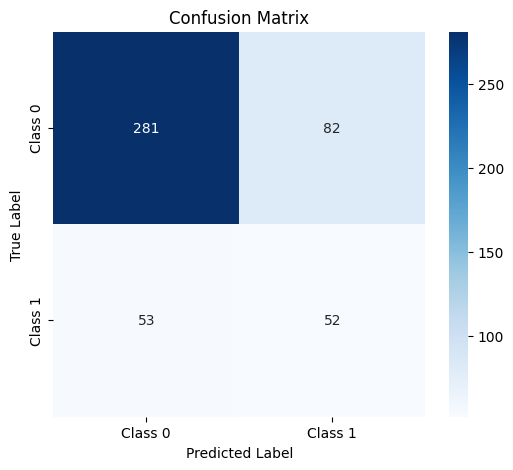


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.81       363
           1       0.39      0.50      0.44       105

    accuracy                           0.71       468
   macro avg       0.61      0.63      0.62       468
weighted avg       0.74      0.71      0.72       468



In [ ]:
evaluate_model(model_2, X_test_mfcc_padded_fed, y_test)

### Model 2.2 - Monitor on AUC

As the data is imbalanced, an experiement is conducted on monitoring AUC in training with best model as of now(model 2) without changing its structure.

It provides insights into the model's ability to separate the two classes across all thresholds, making it more reliable for imbalanced datasets than accuracy alone.

In [ ]:
# Early stopping callback with a larger patience
early_stopping = EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max')

In [ ]:
# Build the CNN model
model_2_2 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten & Fully Connected Layers with L2 Regularization
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # Increased Dropout Rate

    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),  # Increased Dropout Rate

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_2_2.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 100
history_monitorAUC = model_2_2.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4748 - loss: 2.4712 - precision: 0.2929 - recall: 0.6079 - val_accuracy: 0.5868 - val_loss: 2.1721 - val_precision: 0.2681 - val_recall: 0.2984 - learning_rate: 1.0000e-04
Epoch 2/100
  9/114 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5949 - loss: 2.1494 - precision: 0.2664 - recall: 0.4268

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
  current = self.get_monitor_value(logs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5608 - loss: 2.1740 - precision: 0.3102 - recall: 0.5425 - val_accuracy: 0.5670 - val_loss: 2.1370 - val_precision: 0.3069 - val_recall: 0.4677 - learning_rate: 1.0000e-04
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5314 - loss: 2.1408 - precision: 0.3081 - recall: 0.5569 - val_accuracy: 0.6132 - val_loss: 2.0782 - val_precision: 0.3556 - val_recall: 0.5161 - learning_rate: 1.0000e-04
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5558 - loss: 2.0765 - precision: 0.3331 - recall: 0.6292 - val_accuracy: 0.6352 - val_loss: 2.0268 - val_precision: 0.3820 - val_recall: 0.5484 - learning_rate: 1.0000e-04
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5664 - loss: 2.0294 - precision: 0.3463 - recall: 0.6578 - val_accuracy: 0.6000 - val_loss: 2.0004 - val_precision: 0.3550 - val_recall: 0.5726 - learning_rate: 1.0000e-04
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/ste

In [ ]:
evaluate_test_set(model_2_2, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7081 - loss: 1.3957 - precision: 0.3789 - recall: 0.5019
Test Loss: 1.4041
Test Accuracy: 0.6944
Test Precision: 0.3603
Test Recall: 0.4667


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


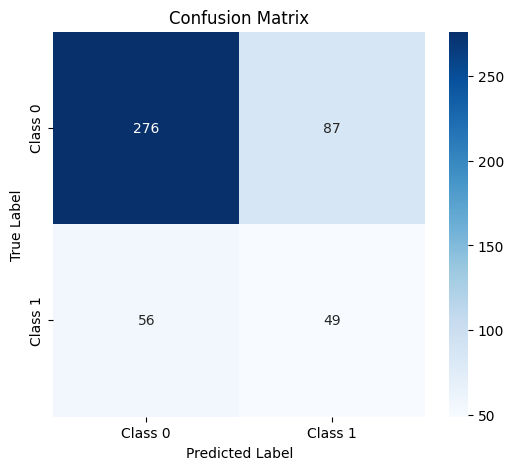


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79       363
           1       0.36      0.47      0.41       105

    accuracy                           0.69       468
   macro avg       0.60      0.61      0.60       468
weighted avg       0.73      0.69      0.71       468



In [ ]:
evaluate_model(model_2_2, X_test_mfcc_padded_fed, y_test)

early stopping is not called by the end of the training. The model still performce badly

### Model 3 - CNN-LSTM

Now we add LSTM layer to the CNN model above. Reset the earlying stopping conditions.

In [ ]:
# Reset back the early stopping conditions:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Build the CNN-LSTM Model
model_3 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Reshape output for LSTM compatibility
    Reshape((-1, 64)),  # Convert feature map to (time_steps, features)

    # LSTM Layer
    LSTM(64, return_sequences=False),  # Use return_sequences=True for stacking LSTMs
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_3.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_cnnlstm = model_3.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6432 - loss: 2.4195 - precision: 0.2256 - recall: 0.1541 - val_accuracy: 0.4879 - val_loss: 2.3040 - val_precision: 0.3225 - val_recall: 0.7984 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5673 - loss: 2.2876 - precision: 0.2653 - recall: 0.3569 - val_accuracy: 0.4088 - val_loss: 2.2035 - val_precision: 0.2911 - val_recall: 0.8145 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5604 - loss: 2.1821 - precision: 0.3220 - recall: 0.5213 - val_accuracy: 0.5055 - val_loss: 2.0796 - val_precision: 0.3190 - val_recall: 0.7177 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5508 - loss: 2.0774 - precision: 0.3201 - recall: 0.5026 - val_accuracy: 0.4549 - val_loss: 1.9938 - val_precision: 0.3063 - val_recall: 0.7903 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [ ]:
evaluate_test_set(model_3, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7289 - loss: 0.8915 - precision: 0.4255 - recall: 0.6403
Test Loss: 0.8958
Test Accuracy: 0.7244
Test Precision: 0.4241
Test Recall: 0.6381


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


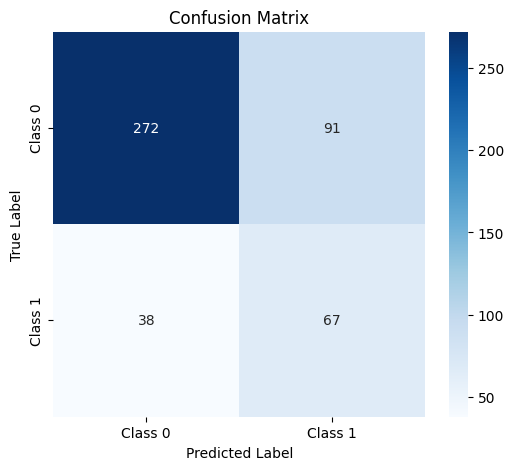


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81       363
           1       0.42      0.64      0.51       105

    accuracy                           0.72       468
   macro avg       0.65      0.69      0.66       468
weighted avg       0.78      0.72      0.74       468



In [ ]:
evaluate_model(model_3, X_test_mfcc_padded_fed, y_test)

The LSTM+CNN model gives us the best balance yet. Comparing the best CNN model before, F1 score for Class1 increase to 0.51 while the Class0 F1 score remains 0.81.

### model 3.2 removing regularisation


In [ ]:
# Build the CNN-LSTM Model
model_3_2 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same', ),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Reshape output for LSTM compatibility
    Reshape((-1, 64)),  # Convert feature map to (time_steps, features)

    # LSTM Layer
    LSTM(64, return_sequences=False),  # Use return_sequences=True for stacking LSTMs
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_3_2.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_cnnlstm_complex = model_3_2.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4272 - loss: 0.7074 - precision: 0.3120 - recall: 0.8278 - val_accuracy: 0.4769 - val_loss: 0.6946 - val_precision: 0.3125 - val_recall: 0.7661 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5040 - loss: 0.6844 - precision: 0.2749 - recall: 0.5520 - val_accuracy: 0.4747 - val_loss: 0.6969 - val_precision: 0.3163 - val_recall: 0.7984 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4766 - loss: 0.6853 - precision: 0.3116 - recall: 0.7115 - val_accuracy: 0.4593 - val_loss: 0.6844 - val_precision: 0.3106 - val_recall: 0.8065 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5104 - loss: 0.6794 - precision: 0.3014 - recall: 0.6625 - val_accuracy: 0.4462 - val_loss: 0.6892 - val_precision: 0.3061 - val_recall: 0.8145 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 3

In [ ]:
evaluate_test_set(model_3_2, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5332 - loss: 0.6419 - precision: 0.3030 - recall: 0.8535
Test Loss: 0.6448
Test Accuracy: 0.5278
Test Precision: 0.3027
Test Recall: 0.8476


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


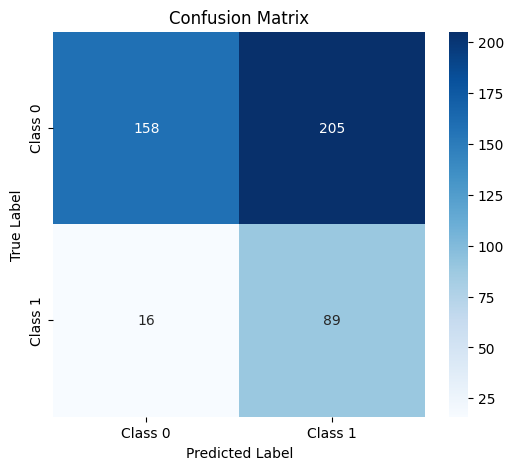


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.44      0.59       363
           1       0.30      0.85      0.45       105

    accuracy                           0.53       468
   macro avg       0.61      0.64      0.52       468
weighted avg       0.77      0.53      0.56       468



In [ ]:
evaluate_model(model_3_2, X_test_mfcc_padded_fed, y_test)

We try to remove regularisation, but the performance is pool.


### Model 3.3 Trying bidirectional LSTM

In [ ]:
# Build the CNN-LSTM Model
model_3_3 = Sequential([
    # Convolutional Layers with L2 Regularization
    Conv2D(16, (3, 3), activation='relu', padding='same',
           input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Reshape output for LSTM compatibility
    Reshape((-1, 64)),  # Convert feature map to (time_steps, features)

    # LSTM Layer
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),

    # Fully Connected Layers
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_3_3.compile(
    optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_cnnlstm_complex = model_3_3.fit(
    X_train_fed, y_train_fed,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_fed, y_val_fed),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.3672 - loss: 2.4109 - precision: 0.2720 - recall: 0.7746 - val_accuracy: 0.5824 - val_loss: 2.2682 - val_precision: 0.3443 - val_recall: 0.5887 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4734 - loss: 2.2366 - precision: 0.2819 - recall: 0.6317 - val_accuracy: 0.6330 - val_loss: 2.1154 - val_precision: 0.3930 - val_recall: 0.6371 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5499 - loss: 2.0855 - precision: 0.3270 - recall: 0.6089 - val_accuracy: 0.6835 - val_loss: 1.9569 - val_precision: 0.4254 - val_recall: 0.4597 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5447 - loss: 1.9531 - precision: 0.2999 - recall: 0.5486 - val_accuracy: 0.5538 - val_loss: 1.8686 - val_precision: 0.3463 - val_recall: 0.7177 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [ ]:
evaluate_test_set(model_3_3, X_test_mfcc_padded_fed, y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7487 - loss: 0.9287 - precision: 0.4346 - recall: 0.4617
Test Loss: 0.9473
Test Accuracy: 0.7372
Test Precision: 0.4167
Test Recall: 0.4286


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


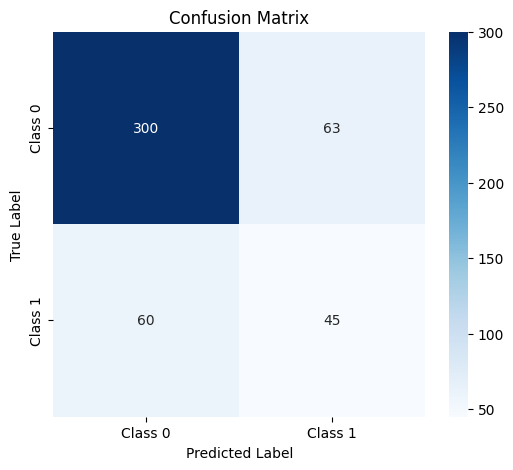


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       363
           1       0.42      0.43      0.42       105

    accuracy                           0.74       468
   macro avg       0.62      0.63      0.63       468
weighted avg       0.74      0.74      0.74       468



In [ ]:
evaluate_model(model_3_3, X_test_mfcc_padded_fed, y_test)

We also try bi-directional LSTM layer,F1 score drops a bit for Class1.

## 4. Machine learning 2 (log-mel)

Beside MFCC, log mel spectrogram is also commonly used. After extracting log-mel features, we apply CNN model on it.


In [ ]:
def extract_logmel(audio, sr):
    """Extract logmel features from raw audio."""
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, fmax=6000)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max).T
    return log_mel  # (frames, features)

In [ ]:
# Process all audio files to extract log-mel features
X_train_logmel = [extract_logmel(audio, sr=12000) for audio in X_train]
X_test_logmel = [extract_logmel(audio, sr=12000) for audio in X_test]

In [ ]:
#Calculate log-mel lengths for all training samples
logmel_lengths = [logmel.shape[0] for logmel in X_train_logmel]

# Compute statistics for log-mel frames
min_frames = np.min(logmel_lengths)
max_frames = np.max(logmel_lengths)
mean_frames = np.mean(logmel_lengths)
median_frames = np.median(logmel_lengths)
percentile_90 = np.percentile(logmel_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(logmel_lengths, 95)  # 95th percentile


# Print results
print(f"Log-mel Statistics:")
print(f"Min frames: {min_frames}")
print(f"Max frames: {max_frames}")
print(f"Mean frames: {mean_frames:.2f}")
print(f"Median frames: {median_frames}")
print(f"90th Percentile frames: {percentile_90}")
print(f"95th Percentile frames: {percentile_95}")

Log-mel Statistics:
Min frames: 7
Max frames: 528
Mean frames: 91.96
Median frames: 87.0
90th Percentile frames: 163.0
95th Percentile frames: 184.0


In [ ]:
# Function to pad or truncate log-mel features to 186 frames
def process_logmel_features(features, target_frames=184):
    """Pad or truncate log-mel spectrograms to the target number of frames."""
    return np.array([pad_or_truncate(f, target_frames) for f in features]) #reuse pad or truncte

In [ ]:
# Apply padding/truncation to log-mel features
X_train_logmel_padded = process_logmel_features(X_train_logmel, 184)[..., np.newaxis]
X_test_logmel_padded = process_logmel_features(X_test_logmel, 184)[..., np.newaxis]

# Check the final shapes
print(f"X_train_logmel_padded shape: {X_train_logmel_padded.shape}")
print(f"X_test_logmel_padded shape: {X_test_logmel_padded.shape}")

X_train_logmel_padded shape: (2271, 184, 64, 1)
X_test_logmel_padded shape: (468, 184, 64, 1)


In [ ]:
# Convert log-mel lists to NumPy arrays (if not already)
X_train_logmel_padded = np.array(X_train_logmel_padded)
X_test_logmel_padded = np.array(X_test_logmel_padded)

# Add channel dimension if not already present
X_train_logmel_padded = X_train_logmel_padded[..., np.newaxis]
X_test_logmel_padded = X_test_logmel_padded[..., np.newaxis]

# Split training data into train and validation sets USE SPLIT INSTEAD OF FED
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_logmel_padded, y_train, test_size=0.2, stratify=y_train, random_state=37
)

# Print the shapes to verify the split
print(f"X_train_split shape: {X_train_split.shape}")
print(f"X_val_split shape: {X_val_split.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"y_val_split shape: {y_val_split.shape}")
print(f"X_test_logmel_padded shape: {X_test_logmel_padded.shape}")

X_train_split shape: (1816, 184, 64, 1, 1)
X_val_split shape: (455, 184, 64, 1, 1)
y_train_split shape: (1816,)
y_val_split shape: (455,)
X_test_logmel_padded shape: (468, 184, 64, 1, 1)


In [ ]:
# Remove the extra channel dimension
X_train_split = np.squeeze(X_train_split, axis=-1)
X_val_split = np.squeeze(X_val_split, axis=-1)
X_test_logmel_padded = np.squeeze(X_test_logmel_padded, axis=-1)

# Check shapes after squeezing
print(f"Fixed X_train_split shape: {X_train_split.shape}")
print(f"Fixed X_val_split shape: {X_val_split.shape}")
print(f"Fixed X_test_logmel_padded shape: {X_test_logmel_padded.shape}")

Fixed X_train_split shape: (1816, 184, 64, 1)
Fixed X_val_split shape: (455, 184, 64, 1)
Fixed X_test_logmel_padded shape: (468, 184, 64, 1)


In [ ]:
print(X_train_split.shape, y_train_split.shape)
print(X_val_split.shape, y_val_split.shape)
print(X_test_logmel_padded.shape, y_test.shape)

(1816, 184, 64, 1) (1816,)
(455, 184, 64, 1) (455,)
(468, 184, 64, 1) (468,)


In [ ]:
# Build the CNN model
model_4 = Sequential([
    # Convolutional Layers
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(184, 64, 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten Layer
    Flatten(name="flatten"),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Print the model summary
model_4.summary()

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)                  │ (None, 184, 64, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_114              │ (None, 184, 64, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_114 (MaxPooling2D)     │ (None, 92, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_115 (Conv2D)                  │ (None, 92, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_115              │ (None, 92, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_115 (MaxPooling2D)     │ (None, 46, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_116 (Conv2D)                  │ (None, 46, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_116              │ (None, 46, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_116 (MaxPooling2D)     │ (None, 23, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11776)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 64)                  │         753,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 779,585 (2.97 MB)

 Trainable params: 779,361 (2.97 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Train the model
num_epochs = 50
history_logmel= model_4.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5791 - loss: 3.3977 - precision: 0.3000 - recall: 0.4383 - val_accuracy: 0.6659 - val_loss: 2.9680 - val_precision: 0.3906 - val_recall: 0.4032 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.5930 - loss: 2.9876 - precision: 0.3435 - recall: 0.5622 - val_accuracy: 0.5011 - val_loss: 2.9157 - val_precision: 0.3180 - val_recall: 0.7258 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5440 - loss: 2.8688 - precision: 0.3260 - recall: 0.6367 - val_accuracy: 0.6000 - val_loss: 2.7952 - val_precision: 0.3505 - val_recall: 0.5484 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.5295 - loss: 2.7729 - precision: 0.2952 - recall: 0.6023 - val_accuracy: 0.5758 - val_loss: 2.6987 - val_precision: 0.3493 - val_recall: 0.6452 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_4, X_test_logmel_padded , y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7358 - loss: 1.4178 - precision: 0.4191 - recall: 0.4803
Test Loss: 1.4604
Test Accuracy: 0.7350
Test Precision: 0.4202
Test Recall: 0.4762


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


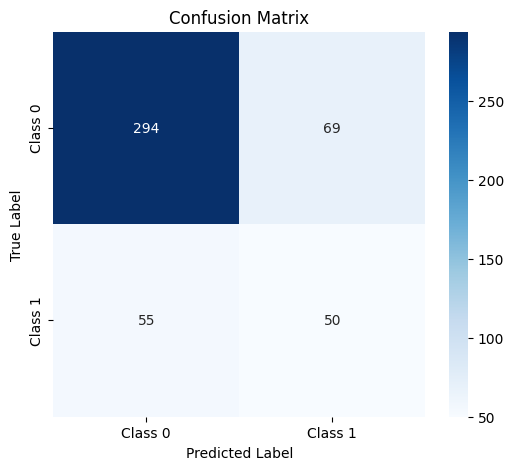


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83       363
           1       0.42      0.48      0.45       105

    accuracy                           0.74       468
   macro avg       0.63      0.64      0.64       468
weighted avg       0.75      0.74      0.74       468



In [ ]:
evaluate_model(model_4, X_test_logmel_padded, y_test)

F1 score for class1 is still low.

### Model 5

Try to remove the regularization and increase model complexity by using much larger Dense layers

In [ ]:
model_5 = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(184,64,1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_5.compile(optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_logmel= model_5.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.5382 - loss: 1.2713 - precision: 0.2142 - recall: 0.4519 - val_accuracy: 0.3893 - val_loss: 0.7779 - val_precision: 0.2456 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.5607 - loss: 0.8593 - precision: 0.2707 - recall: 0.6315 - val_accuracy: 0.5947 - val_loss: 0.6720 - val_precision: 0.3068 - val_recall: 0.6429 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.6409 - loss: 0.6904 - precision: 0.3481 - recall: 0.6544 - val_accuracy: 0.5440 - val_loss: 0.6898 - val_precision: 0.2769 - val_recall: 0.6429 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.6233 - loss: 0.6468 - precision: 0.3444 - recall: 0.6846 - val_accuracy: 0.6507 - val_loss: 0.6199 - val_precision: 0.3444 - val_recall: 0.6190 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 15

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_5, X_test_logmel_padded , y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7179 - loss: 0.5753 - precision: 0.4113 - recall: 0.6409
Test Loss: 0.6041
Test Accuracy: 0.7009
Test Precision: 0.3871
Test Recall: 0.5714


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


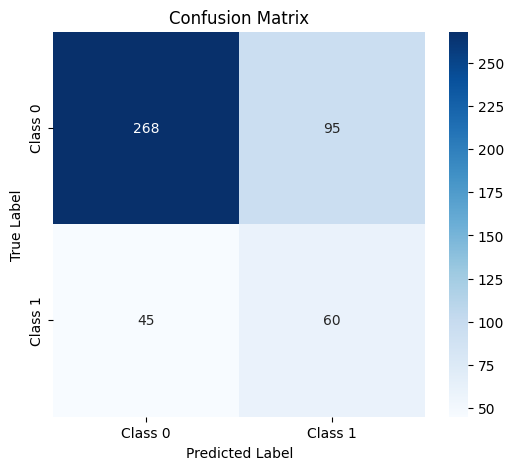


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.79       363
           1       0.39      0.57      0.46       105

    accuracy                           0.70       468
   macro avg       0.62      0.65      0.63       468
weighted avg       0.75      0.70      0.72       468



In [ ]:
evaluate_model(model_5, X_test_logmel_padded, y_test)

The performance does not improve.

### Model 6 CNN+bi-directional LSTM

Combine bi-directional LSTM with CNN network.

In [ ]:
model_6 = Sequential([
    # CNN feature extractor
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(184, 64, 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # At this point, the feature map should be roughly of shape (23, 8, 128)
    # Reshape to (time_steps, features) for the LSTM layers
    Reshape((23, 8 * 64)),

    # LSTM layers for temporal modeling
    Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM (Captures more context)
    LSTM(32, return_sequences=False),  # Second LSTM for deeper representation
    Dropout(0.5),

    # Flatten Layer
    Flatten(name="flatten"),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_6.compile(optimizer=Adam(learning_rate=0.0001), #starting lr
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model
num_epochs = 50
history_logmel_cnnlstm= model_6.fit(
    X_train_split, y_train_split,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler],  #include both callbacks
    class_weight=class_weights_dict
)

print("Model training completed.")

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.5036 - loss: 2.1752 - precision: 0.2681 - recall: 0.5101 - val_accuracy: 0.5319 - val_loss: 2.0613 - val_precision: 0.3394 - val_recall: 0.7581 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.5074 - loss: 2.0364 - precision: 0.3059 - recall: 0.5615 - val_accuracy: 0.5429 - val_loss: 1.9073 - val_precision: 0.3320 - val_recall: 0.6694 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.5711 - loss: 1.8861 - precision: 0.3082 - recall: 0.4626 - val_accuracy: 0.4440 - val_loss: 1.7938 - val_precision: 0.3075 - val_recall: 0.8306 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.5084 - loss: 1.7487 - precision: 0.2909 - recall: 0.6000 - val_accuracy: 0.4967 - val_loss: 1.6687 - val_precision: 0.3171 - val_recall: 0.7339 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate the model on the test set
evaluate_test_set(model_6, X_test_logmel_padded , y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7659 - loss: 0.8170 - precision: 0.4773 - recall: 0.6306
Test Loss: 0.8213
Test Accuracy: 0.7521
Test Precision: 0.4574
Test Recall: 0.5619


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


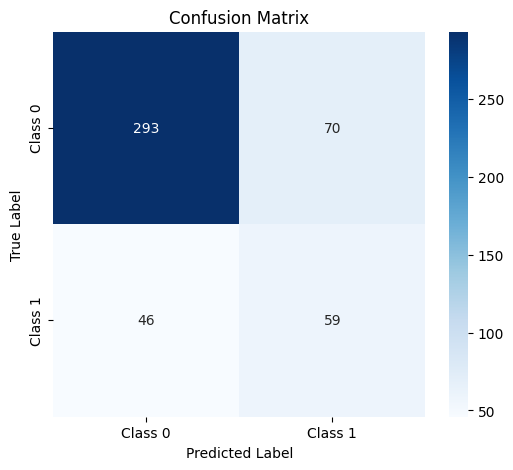


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83       363
           1       0.46      0.56      0.50       105

    accuracy                           0.75       468
   macro avg       0.66      0.68      0.67       468
weighted avg       0.77      0.75      0.76       468



In [ ]:
evaluate_model(model_6, X_test_logmel_padded, y_test)

After adding bi-directional LSTM layer, accuracy and F1 scores improve a lot. The model learn more features and behave well.